In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

import codecs, json 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import scipy
import time

import scipy_interpolation_functions as scipy_int

In [2]:
def read_data():    
    with open('data_rich_ac.bsad') as json_file:
        json_data = json.load(json_file)

    frames = []
    for j in range(len(json_data['tables'])):
        df = pd.DataFrame(np.array(json_data['tables'][j]['table'])[:,:], 
                               columns = json_data['tables'][j]['header']['variables'][:])
        df['state'] = json_data['tables'][j]['header']['flightphase']
        if df['state'][0] == 'cruise':
            frames.append(df)

    df = pd.concat(frames,ignore_index=True)
    df = df[['DISA','ALTITUDE','MASS','MACH','DRAG']]

    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)

    df = pd.DataFrame(df, columns = ['DISA','ALTITUDE','MASS','MACH','DRAG'])

    X = df.drop(['DRAG'], axis=1)
    y = df.DRAG

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001)
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = read_data()

In [ ]:
##################################################################

#Pandas linear

##################################################################

C:\Anaconda\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Time:  7.376078844070435
MSE:  0.2161543933650265


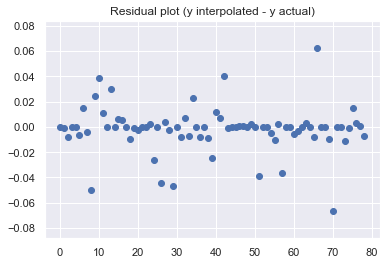

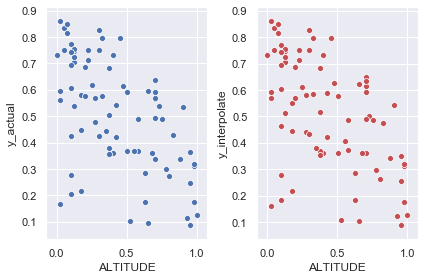

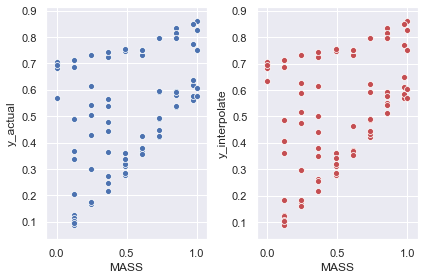

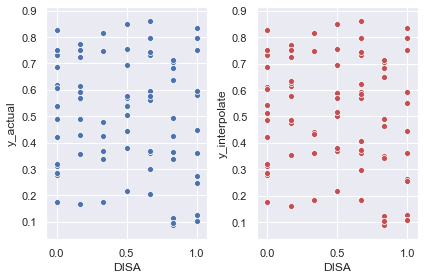

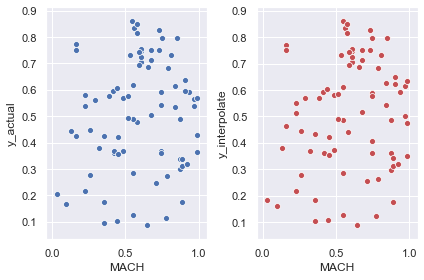

In [5]:
start = time.time()

output = np.zeros((len(y_test), 2))

for i in range(len(X_test)):
    test = X_test.iloc[i]
    y_check = y_test.iloc[i]
    
    X_train_1 = X_train.copy()
    X_train_1['distance'] = X_train_1.sub(test).pow(2).sum(1).pow(0.5) # maybe cutoff based on input

    end = 16
    z = X_train_1.sort_values('distance').iloc[0:end]
    z = z.drop(['distance'],axis = 1)
    z = z.reset_index()
    z.columns = ['index_', 'DISA', 'ALTITUDE', 'MASS', 'MACH']
    y_train.columns = ['index_', 'DRAG']
    z = z.join(y_train, on = 'index_', how = 'left')
    z = z.drop(['index_'], axis=1)

    z_inter = z[0:1].append(test)
    z_inter = z_inter.append(z[2:end])

    y_inter = z_inter.interpolate(method = 'linear')['DRAG']
    
    output[i,0] = y_check
    output[i,1] = y_inter.iloc[1]
    
end = time.time()

print('Time: ',end - start)
print('MSE: ', mean_squared_error(output[0], output[1]))

plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
plt.title('Residual plot (y interpolated - y actual)')
plt.show()

X_test['y_interpolate'] = output[:,1]
X_test['y_actual'] = output[:,0]

plt.subplot(1,2,1)
sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MASS', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MASS', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='DISA', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='DISA', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MACH', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MACH', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

In [ ]:
##################################################################

#Scipy linear

##################################################################

Time:  97.25284218788147
MSE:  0.21655452179822093


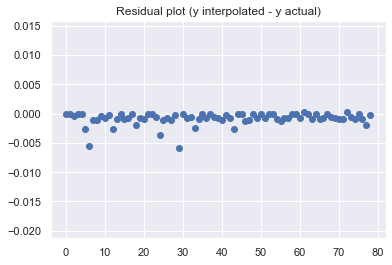

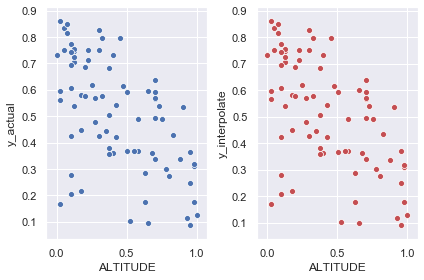

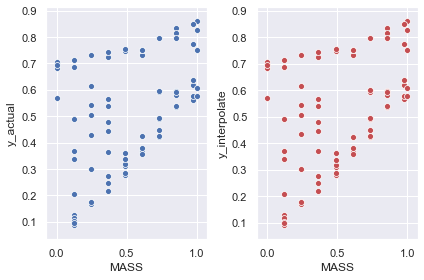

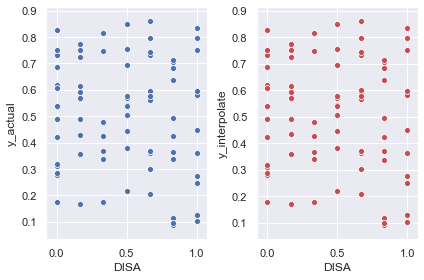

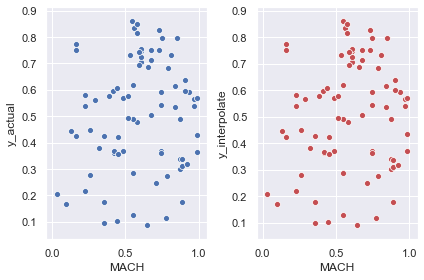

In [6]:
X_train_scipy = X_train.copy()
X_train_scipy['DRAG'] = y_train

X_test = X_test.drop(['y_interpolate', 'y_actual'], axis=1)

start = time.time()

output = np.zeros((len(y_test), 2))

for i in range(len(X_test)):
    test = X_test.iloc[i]
    y_check = y_test.iloc[i]
    
    y_inter = scipy_int.scipy_interpolation_linear(X_train_scipy, test, 'DRAG')
    
    if np.isnan(y_inter)== True : #Extrapolate
        y = X_train_scipy.FUELFLOW
        X = X_train_scipy.drop(['DRAG'], axis=1)
        point,value = scipy_int.closest_points(X,y,test,1)
        y_inter = value
    
    output[i,0] = y_check
    output[i,1] = y_inter[0]
    
end = time.time()

print('Time: ',end - start)
print('MSE: ', mean_squared_error(output[0], output[1]))

plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
plt.title('Residual plot (y interpolated - y actual)')
plt.show()

X_test['y_interpolate'] = output[:,1]
X_test['y_actual'] = output[:,0]

plt.subplot(1,2,1)
sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MASS', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MASS', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='DISA', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='DISA', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MACH', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MACH', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

In [ ]:
##################################################################

#Scipy nearest

##################################################################

Time:  9.772566318511963
MSE:  0.2164511199805176


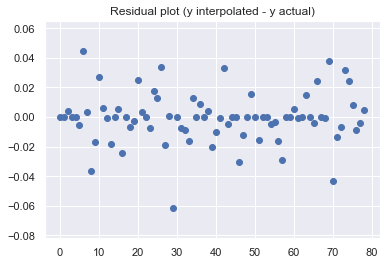

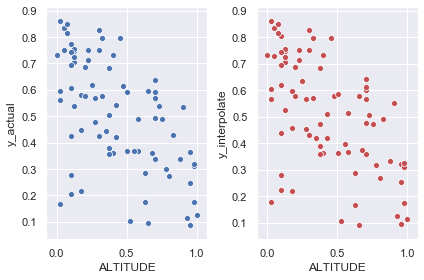

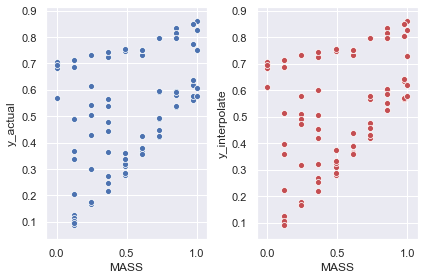

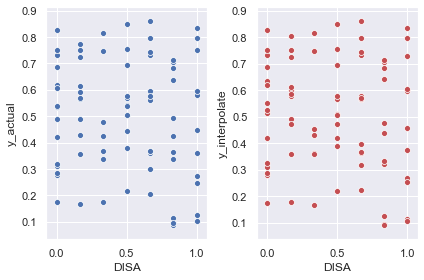

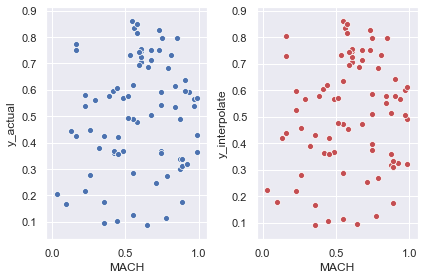

In [4]:
X_train_scipy = X_train.copy()
X_train_scipy['DRAG'] = y_train

#X_test = X_test.drop(['y_interpolate', 'y_actual'], axis=1)

start = time.time()

output = np.zeros((len(y_test), 2))

for i in range(len(X_test)):
    test = X_test.iloc[i]
    y_check = y_test.iloc[i]
    
    y_inter = scipy_int.scipy_interpolation_nearest(X_train_scipy, test, 'DRAG')

    output[i,0] = y_check
    output[i,1] = y_inter.iloc[0]
    
end = time.time()

print('Time: ',end - start)
print('MSE: ', mean_squared_error(output[0], output[1]))

plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
plt.title('Residual plot (y interpolated - y actual)')
plt.show()

X_test['y_interpolate'] = output[:,1]
X_test['y_actual'] = output[:,0]

plt.subplot(1,2,1)
sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MASS', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MASS', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='DISA', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='DISA', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='MACH', y='y_actual', data = X_test, color ='b')
plt.subplot(1,2,2)
sns.scatterplot(x='MACH', y= 'y_interpolate', data = X_test, color ='r')
plt.tight_layout()
plt.show()